# Adding Additional Passbands/Transmission Curves in FORECASTOR

Tyrone Woods - August 2022

This notebook provides an overview of how to customize the FORECASTOR photometry ETC to add new transmission curves. If this is your first time using the ETC, please first consult the other tutorial notebooks found at: https://github.com/CASTOR-telescope/ETC_notebooks

At the time of writing, the current distribution of the FORECASTOR photometry ETC comes with three transmission curves, one for each of the 3 reference design passbands (UV, u, and g). In the following, we construct a Telescope Object with four additional transmission curves, corresponding to UV and u passbands each with the inclusion of either a longpass or bandpass filter, two proposed additions to the CASTOR filter wheel presently under consideration.

In this example, the proposed longpass filter has a short wavelength cutoff at 225nm, while the proposed bandpass filter has a short wavelength cutoff at 225nm and a long wavelength cutoff at 300nm. The transmission curves for the 4 combinations of these two filters with the UV and u bands (uv_split_lp, u_split_lp, uv_split_bb, and u_split_bb) are found in the "data" subdirectory in this folder. Please consider these curves very provisional -- they are strictly for the purpose of assessing the value of an additional filter and are strictly notional. In particular, no assessment of the red leak given these filters can be made at this time.


In [32]:
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from os.path import join
import os

from castor_etc.telescope import Telescope
from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import PointSource
from castor_etc import parameters as params

First we define the names of the new transmission curves and add them to set of bands that FORECASTOR looks for.

In [33]:
FILTER_BANDS = ["uv_split_lp", "uv_split_bb", "u_split_lp", "u_split_bb"]
BANDS = params.PASSBANDS + FILTER_BANDS

Then we specify the passband limits for these curves as well as the units for wavelength in the transmission curves, and add them to the appropriate lists.

In [34]:
BAND_limits = params.PASSBAND_LIMITS
BAND_limits.update({"uv_split_lp": [0.225, 0.300] << u.um,
                    "uv_split_bb": [0.225, 0.300] << u.um,
                    "u_split_lp": [0.300, 0.400] << u.um,
                    "u_split_bb": [0.300, 0.350] << u.um,})

fileunits = params.PASSBAND_FILEUNITS
FILEUNITS_FILTERS = {"uv_split_lp": u.um, "uv_split_bb": u.um, "u_split_lp": u.um, "u_split_bb": u.um}
fileunits.update(FILEUNITS_FILTERS)

We then specify the filepath where the new filter-modified transmission curves are found.

In [50]:
filepaths = params.PASSBAND_FILEPATHS
#DATAPATH='/arc/projects/CASTOR/FilterExample/Data/'
DATAPATH=os.getcwd() + "/data/"
FILEPATHS_FILTERS = {
    band: join(DATAPATH, f"passband_castor.{band}") for band in FILTER_BANDS
}
filepaths.update(FILEPATHS_FILTERS)

Next we choose threshold wavelengths beyond which any measured flux is considered "red leak". Note that these are {\bf extremely} notional values; additional study is necessary before the red leak for any band+filter combination can be assessed.

In [41]:
redleak_thresholds = params.REDLEAK_THRESHOLDS
redleak_filters = {"uv_split_lp": 3010 << u.AA,
                   "uv_split_bb": 3010 << u.AA,
                   "u_split_lp": 4160 << u.AA,
                   "u_split_bb": 3500 << u.AA}
redleak_thresholds.update(redleak_filters)

We then set extinction coefficients are the new filters; here we have matched the values for the band+filter combinations to the same as the default values for the bands (UV, u) without any filter, as taken from Yuan+2013.

In [42]:
extinction_coefs = params.EXTINCTION_COEFFS
extinction_filters = {"uv_split_lp": 7.06,
                      "uv_split_bb": 7.06,
                      "u_split_lp": 4.35,
                      "u_split_bb": 4.35}
extinction_coefs.update(extinction_filters)

Finally, we provide an updated list of the upper and lower bounds for FORECASTOR to use in computing the photometric zeropoints in each band, so as to include appropriate values for the added band+filter combinations.

In [43]:
phot_zpts={
    "ab_mags": {"uv": [25.5, 23.5], "u": [25.5, 23.5], "g": [25.5, 23.5],
                "uv_split_lp": [25.5, 23.5], "uv_split_bb": [25.5, 23.5],
                "u_split_lp": [25.5, 23.5], "u_split_bb": [25.5, 23.5]},
    "method": "secant",
    "tol": 2e-4,
    "max_iter": 100,
} 

We can now create a Telescope object which will include the newly created band+filter combinations, in addition to the standard UV, u, and g bands.

In [44]:
MyTelescope = Telescope(passbands=BANDS,
                        passband_limits=BAND_limits,
                        passband_response_filepaths=filepaths,
                        passband_response_fileunits=fileunits,
                        redleak_thresholds=redleak_thresholds,
                        extinction_coeffs=extinction_coefs,
                        phot_zpts_kwargs=phot_zpts)

In [45]:
MyTelescope.passbands

['uv', 'u', 'g', 'uv_split_lp', 'uv_split_bb', 'u_split_lp', 'u_split_bb']

As a first check, let's compare the new band+filter transmission curves with the original three bands, first for the long pass filter:

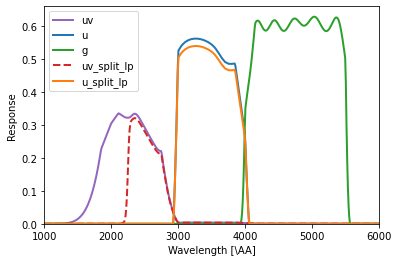

In [46]:
# 
# Plot the curves
# 
# Set line properties for each of the UV-, u-, and g-bands
colors = ["tab:purple", "tab:blue", "tab:green", "tab:red", "tab:orange"]
linestyles = ["solid", "solid", "solid", "--", "-"]
# 
fig, ax = plt.subplots()
for band, color, ls in zip(['uv', 'u', 'g', 'uv_split_lp', 'u_split_lp'], colors, linestyles):
    ax.plot(
        MyTelescope.full_passband_curves[band]["wavelength"].to(u.AA).value,
        MyTelescope.full_passband_curves[band]["response"],
        color=color,
        ls=ls,
        lw=2,
        label=band,
    )
ax.set_xlim(1000, 6000)
ax.set_ylim(bottom=0)
ax.set_xlabel(r"Wavelength [\AA]")
ax.set_ylabel("Response")
ax.legend()
plt.show()

... and then for the bandpass filter:

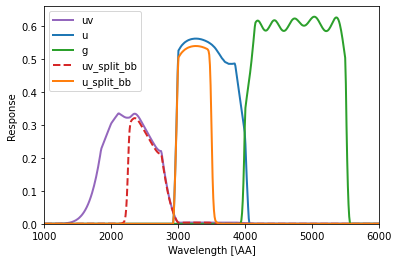

In [47]:
# 
# Plot the curves
# 
# Set line properties for each of the UV-, u-, and g-bands
colors = ["tab:purple", "tab:blue", "tab:green", "tab:red", "tab:orange"]
linestyles = ["solid", "solid", "solid", "--", "-"]
# 
fig, ax = plt.subplots()
for band, color, ls in zip(['uv', 'u', 'g', 'uv_split_bb', 'u_split_bb'], colors, linestyles):
    ax.plot(
        MyTelescope.full_passband_curves[band]["wavelength"].to(u.AA).value,
        MyTelescope.full_passband_curves[band]["response"],
        color=color,
        ls=ls,
        lw=2,
        label=band,
    )
ax.set_xlim(1000, 6000)
ax.set_ylim(bottom=0)
ax.set_xlabel(r"Wavelength [\AA]")
ax.set_ylabel("Response")
ax.legend()
plt.show()

We can also look at the integration times needed to reach a S/N of either 5 or 10 for thew filter combinations, and compare then with the results for the three passbands alone.

We will assume a typical sky background with average geocoronal emission, following the same procedure as used to compute the S/N table before:

https://github.com/CASTOR-telescope/ETC_notebooks/blob/master/snr_table.ipynb

In [48]:
MyBackground = Background()
MyBackground.add_geocoronal_emission("avg")

TARGET_SNRS = [5, 10]
AB_MAGS = np.arange(22, 29, 0.5)
REDDENING = 0.0

wavelengths = np.arange(90, 1200) * u.nm  # generate the spectrum over these wavelengths

# Make some dictionaries to store the results of our calculations
times_to_one_snr = dict.fromkeys(AB_MAGS)
times_to_reach_snrs = {snr: times_to_one_snr.copy() for snr in TARGET_SNRS}

for ab_mag in AB_MAGS:
    #
    # Initialize a point source and generate a flat spectrum in units of AB magnitude
    #
    MySource = PointSource()
    MySource.generate_uniform(wavelengths=wavelengths, value=ab_mag, unit="ABmag")
    #
    # Initialize a Photometry object and use an optimal aperture for a point source
    #
    MyPhot = Photometry(MyTelescope, MySource, MyBackground)
    MyPhot.use_optimal_aperture(quiet=True)  # don't print encircled energy fraction
    for snr in TARGET_SNRS:
        #
        # Find the time, in seconds, required to reach the specified signal-to-noise ratio
        #
        times_to_reach_snrs[snr][ab_mag] = MyPhot.calc_snr_or_t(
            snr=snr, reddening=REDDENING
        )



In [49]:
for snr in TARGET_SNRS:
    print(f"Times (s) required to reach S/N = {snr}")
    display(pd.DataFrame(times_to_reach_snrs[snr]).T)

Times (s) required to reach S/N = 5


,uv,u,g,uv_split_lp,uv_split_bb,u_split_lp,u_split_bb
22.0,4.957908,4.593260,3.779018,11.074415,11.186604,4.787640,8.135997
22.5,7.863590,7.293252,6.039466,17.579461,17.757011,7.601895,12.909616
23.0,12.477614,11.592785,9.698436,27.931201,28.211951,12.083391,20.497892
23.5,19.812547,18.458275,15.691195,44.443144,44.886470,19.239457,32.581343
24.0,31.493464,29.468363,25.682353,70.878689,71.577184,30.715578,51.875416
24.5,50.147026,47.243975,42.781496,113.447110,114.543662,49.243696,82.815112
25.0,80.065199,76.241466,73.147130,182.610644,184.321778,79.469018,132.761915
25.5,128.376954,124.297443,129.774100,296.536362,299.179388,129.560466,214.228386
26.0,207.211699,205.827268,241.765618,488.093705,492.103317,214.545210,349.208055
26.5,337.918757,348.870584,477.395276,819.953228,825.836127,363.654128,578.133777


Times (s) required to reach S/N = 10


,uv,u,g,uv_split_lp,uv_split_bb,u_split_lp,u_split_bb
22.0,15.676781,14.536679,12.022184,35.040626,35.394737,15.151856,25.734442
22.5,24.873186,23.101551,19.286615,55.664528,56.224563,24.079205,40.855829
23.0,39.489591,36.770523,31.153713,88.546271,89.430861,38.326695,64.926752
23.5,62.758298,58.672263,50.855618,141.150908,142.545317,61.155471,103.340938
24.0,99.896355,93.983071,84.345369,225.758355,227.949236,97.961071,164.888295
24.5,159.409359,151.456523,143.177495,362.962974,366.386945,157.867987,264.108401
25.0,255.375532,246.357669,251.090546,588.267603,593.571521,256.788481,425.581486
25.5,411.616818,406.414427,459.600175,965.203409,973.296684,423.626982,692.154237
26.0,669.709967,684.583921,885.788886,1612.953886,1624.979175,713.589643,1141.613012
26.5,1105.256787,1187.849839,1804.992244,2767.673839,2784.669711,1238.207957,1922.426862
